In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
import requests
import json
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/covid19countryinfo.csv
./input/states-daily.csv
./input/covid19-deepscore.csv
./input/population_data.csv
./input/full-list-total-tests-for-covid-19.csv
./input/country_codes.csv
./input/enriched_covid_19_week_2.csv
./input/covid19-global-forecasting-week-3/test.csv
./input/covid19-global-forecasting-week-3/submission.csv
./input/covid19-global-forecasting-week-3/train.csv
./input/korea/SeoulFloating.csv
./input/korea/TimeAge.csv
./input/korea/SearchTrend.csv
./input/korea/TimeProvince.csv
./input/korea/Weather.csv
./input/korea/PatientRoute.csv
./input/korea/PatientInfo.csv
./input/korea/Region.csv
./input/korea/TimeGender.csv
./input/korea/Case.csv
./input/korea/Time.csv
./input/covid19-global-forecasting-week-2/test.csv
./input/covid19-global-forecasting-week-2/submission.csv
./input/covid19-global-forecasting-week-2/train.csv
./input/covidAPI/ESP.json
./input/covidAPI/ICL.json
./input/covidAPI/CHN.json
./input/covidAPI/FRA.json
./input/covidAPI/THA.json
./input/covidAPI/DNK

# 2. Preparing the training data

In [2]:
def code_to_entity(code):
    dic = {"KOR": "South Korea", "ITA": "Italy", "FRA": "France", "DEU": "Germany", "ISL": "Iceland", "DNK": "Denmark", "THA": "Thailand", "TWN": "Taiwan"}
    return dic[code]

In [3]:
# Get API data (confirmed, deaths, recovered)
# filter by country codes
country_codes = ["KOR", "ITA", "FRA", "DEU", "ISL", "DNK", "THA", "TWN"]

for country in country_codes:
    response = requests.get('https://covidapi.info/api/v1/country/{}'.format(country))
    try:
        data = response.json()
    except:
        print("{} not found".format(country))
    with open("./input/covidAPI/{}.json".format(country), "w") as f:
        json.dump(data["result"], f, indent=4)

In [4]:
original_df = pd.read_csv("./input/full-list-total-tests-for-covid-19.csv")

# unify date format
original_df["Date"] = [datetime.strftime(datetime.strptime(date, '%b %d, %Y'), '%Y-%m-%d') for date in original_df["Date"]]
original_df = original_df.rename(columns={"Total tests": "test"})
original_df.head()

,Entity,Code,Date,test
0,Argentina,ARG,2020-04-08,13330
1,Argentina,ARG,2020-04-09,14850
2,Argentina,ARG,2020-04-10,16379
3,Argentina,ARG,2020-04-11,18027
4,Argentina,ARG,2020-04-13,19758


In [5]:
original_df = original_df.query("Code in {}".format(country_codes))
original_df.reset_index(inplace=True, drop=True)
original_df.head()

,Entity,Code,Date,test
0,Denmark,DNK,2020-03-17,7630
1,Denmark,DNK,2020-03-19,8847
2,Denmark,DNK,2020-03-20,11657
3,Denmark,DNK,2020-03-21,12351
4,Denmark,DNK,2020-03-22,12843


In [6]:
# Merge Dataframe
import json

new_df = original_df
for code in country_codes:
    with open("./input/covidAPI/{}.json".format(code), "r") as f:
        j = json.load(f)
    # for each date
    for key in j.keys():
        # for each in (confirmed, deaths, recovered)
        for k in j[key].keys():
            if ((new_df['Code'] == code) & (new_df['Date'] == key)).any():
                new_df.loc[(new_df["Code"] == code) & (new_df["Date"] == key), k] = j[key][k]
            else:
                s = pd.Series([code_to_entity(code), code, key, j[key][k]], index=["Entity", "Code", "Date", k])
                new_df = new_df.append(s,ignore_index=True)
new_df = new_df.sort_values(['Code', 'Date'])
new_df.reset_index(inplace=True, drop=True)
print(new_df.head())

    Entity Code        Date  test  confirmed  deaths  recovered
0  Germany  DEU  2020-01-22   NaN        0.0     0.0        0.0
1  Germany  DEU  2020-01-23   NaN        0.0     0.0        0.0
2  Germany  DEU  2020-01-24   NaN        0.0     0.0        0.0
3  Germany  DEU  2020-01-25   NaN        0.0     0.0        0.0
4  Germany  DEU  2020-01-26   NaN        0.0     0.0        0.0


In [7]:
# Interpolate
new_df["test"].where(new_df["confirmed"] != 0.0, 0.0, inplace=True)
# add test values to unique countries
for code in ["THA", "TWN"]:
    first_confirmed = new_df.loc[(new_df["Code"] == code) & (new_df["Date"] == "2020-01-22"), "confirmed"].values[0]
    new_df.loc[(new_df["Code"] == code) & (new_df["Date"] == "2020-01-22"), "test"] = new_df.loc[(new_df["Code"] == "KOR") & (new_df["confirmed"] == first_confirmed), "test"].values[0]

for code in country_codes:
    tmp_df = new_df[new_df["Code"] == code]
    tmp_df.interpolate(inplace=True)
    new_df[new_df["Code"]==code] = tmp_df
print(new_df.head())

/Users/Skrimson64/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


    Entity Code        Date  test  confirmed  deaths  recovered
0  Germany  DEU  2020-01-22   0.0        0.0     0.0        0.0
1  Germany  DEU  2020-01-23   0.0        0.0     0.0        0.0
2  Germany  DEU  2020-01-24   0.0        0.0     0.0        0.0
3  Germany  DEU  2020-01-25   0.0        0.0     0.0        0.0
4  Germany  DEU  2020-01-26   0.0        0.0     0.0        0.0


In [8]:
# Add rates
# new_df["infectious_rate"] = (new_df["test"] - new_df["negative"]) / new_df["test"]
new_df["infectious_rate"] = new_df["confirmed"] / new_df["test"]
new_df["removed_rate"] = (new_df["deaths"] + new_df["recovered"]) / new_df["test"]
new_df["susceptible_rate"] = 1.0 - (new_df["infectious_rate"] + new_df["removed_rate"])
new_df["infectious_rate_change"] = 0.0
new_df["removed_rate_change"] = 0.0
new_df["susceptible_rate_change"] = 0.0

# Drop nulls
new_df.dropna(how='any', inplace=True)
print(new_df.head())

    Entity Code        Date          test  confirmed  deaths  recovered  \
5  Germany  DEU  2020-01-27   2969.428571        1.0     0.0        0.0   
6  Germany  DEU  2020-01-28   5938.857143        4.0     0.0        0.0   
7  Germany  DEU  2020-01-29   8908.285714        4.0     0.0        0.0   
8  Germany  DEU  2020-01-30  11877.714286        4.0     0.0        0.0   
9  Germany  DEU  2020-01-31  14847.142857        5.0     0.0        0.0   

   infectious_rate  removed_rate  susceptible_rate  infectious_rate_change  \
5         0.000337           0.0          0.999663                     0.0   
6         0.000674           0.0          0.999326                     0.0   
7         0.000449           0.0          0.999551                     0.0   
8         0.000337           0.0          0.999663                     0.0   
9         0.000337           0.0          0.999663                     0.0   

   removed_rate_change  susceptible_rate_change  
5                  0.0        

In [9]:
# Smoothing
def mu_sigma_justify(Y, floor_n=1, ceil_n=1.5, mu=None, sigma=None):
    """μとσを用いた補正関数。
    Args:
        floor_n (float):
        ceil_n (float):
        mu (Optional[float]):
        sigma (Optional[float]):
    """
    mu = mu or Y.mean()
    sigma = sigma or Y.std()
    Y = Y.copy()
    Y_ = Y.copy()
    Y[abs(Y_ - mu) < floor_n * sigma] = mu  # μ±σ ⇒ μ
    Y[Y_ > mu + ceil_n * sigma] = mu + ceil_n * sigma  # μ＋3σ より大きい ⇒ μ＋3σ
    Y[Y_ < mu - ceil_n * sigma] = mu - ceil_n * sigma  # μー3σ より小さい ⇒ μー3σ
    return Y

In [10]:
def compare_smoothing(df):
    plt.plot(tmp_df["infectious_rate"].values)
    plt.plot(mu_sigma_justify(tmp_df["infectious_rate"].values))
    plt.title("Infectious Rate Smoothing Comparison")
    plt.ylabel('Infectious Rate')
    plt.xlabel('Date')
    plt.xticks(range(len(df["Date"].values)),df["Date"].values,rotation='vertical')
    plt.legend(['Before', 'After'], loc='best')
    plt.show()
    
    plt.plot(tmp_df["removed_rate"].values)
    plt.plot(mu_sigma_justify(tmp_df["removed_rate"].values))
    plt.title("Removed Rate Smoothing Comparison")
    plt.ylabel('Removed Rate')
    plt.xlabel('Date')
    plt.xticks(range(len(df["Date"].values)),df["Date"].values,rotation='vertical')
    plt.legend(['Before', 'After'], loc='best')
    plt.show()

def display_rate(tmp_df):
    plt.plot(tmp_df["infectious_noise_rate"].values)
    plt.plot(tmp_df["removed_noise_rate"].values)
#     plt.plot(tmp_df["susceptible_noise_rate"].values)
    plt.title("Rate")
    plt.ylabel('Rate')
    plt.xlabel('Date')
    plt.xticks(range(len(tmp_df.Date.values)),tmp_df.Date.values,rotation='vertical')
    plt.legend(['Infectious Rate', 'Removed Rate'], loc='best')
    plt.show()

In [11]:
# Calculate Change Rate
for code in country_codes:
    print("-----------------{}------------------".format(code))

    # normalize
    # compare_smoothing(tmp_df)
    # tmp_df["infectious_rate"] = mu_sigma_justify(tmp_df["infectious_rate"].values)
    # tmp_df["removed_rate"] = mu_sigma_justify(tmp_df["removed_rate"].values)
    # tmp_df["susceptible_rate"] = mu_sigma_justify(tmp_df["susceptible_rate"].values)

    tmp_df = new_df[new_df["Code"] == code]
    tmp_df["infectious_rate_change"] = tmp_df["infectious_rate"].pct_change()
    tmp_df["infectious_rate_change"] = tmp_df["infectious_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    tmp_df["removed_rate_change"] = tmp_df["removed_rate"].pct_change()
    tmp_df["removed_rate_change"] = tmp_df["removed_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    tmp_df["susceptible_rate_change"] = tmp_df["susceptible_rate_change"].pct_change()
    tmp_df["susceptible_rate_change"] = tmp_df["susceptible_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)

    new_df[new_df["Code"]==code] = tmp_df
    
# Save
new_df.to_csv("./input/covid19-deepscore.csv")

-----------------KOR------------------


/Users/Skrimson64/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/Skrimson64/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/Skrimson64/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

-----------------ITA------------------
-----------------FRA------------------
-----------------DEU------------------
-----------------ISL------------------
-----------------DNK------------------
-----------------THA------------------
-----------------TWN------------------


In [12]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def gamma(x):
    return x * x * 1/50000

In [13]:
# Creating SIR inputs
from scipy.integrate import odeint
import random

# A grid of time points (in days)
days = 160

# Initial SIR dataframe
cols = ['Code', 'Date', 'confirmed', 'removed', 'susceptible', 'infectious_rate', 'removed_rate', 'susceptible_rate']
SIR_df = pd.DataFrame(index=[], columns=cols)

dates = [d.strftime("%Y-%m-%d") for d in pd.date_range(start='2020-02-01', periods=days, freq='D')]
print(dates)

['2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020

--------------------------------------------------------
first beta=1.658883141307362e-06, first gamma=0.0
last beta=2.8605901115063232e-08, last gamma=0.50562


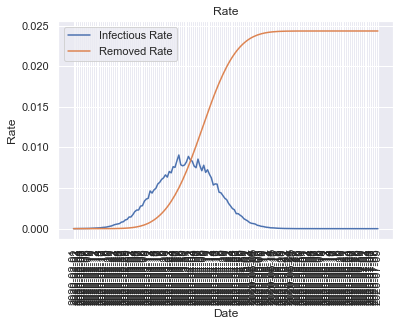

/Users/Skrimson64/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:66: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



--------------------------------------------------------
first beta=1.5596085490996857e-06, first gamma=0.0
last beta=1.7660591419053484e-08, last gamma=0.50562


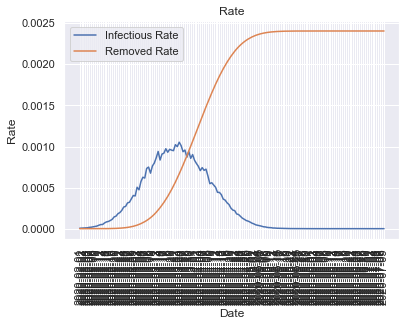

--------------------------------------------------------
first beta=1.8186649642963658e-06, first gamma=0.0
last beta=4.256991558658258e-08, last gamma=0.50562


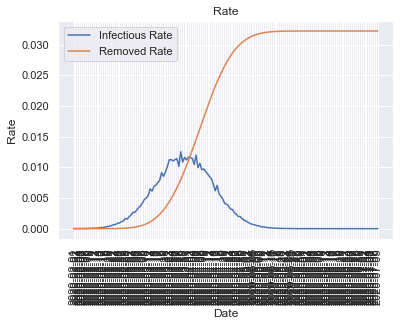

--------------------------------------------------------
first beta=1.687983740709721e-06, first gamma=0.0
last beta=2.3398361873097413e-08, last gamma=0.50562


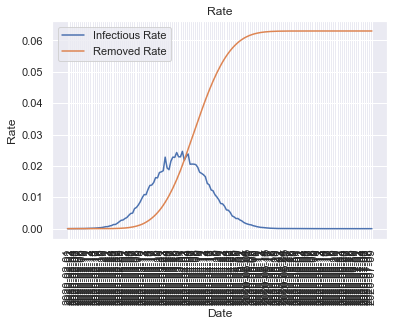

--------------------------------------------------------
first beta=1.768305614186068e-06, first gamma=0.0
last beta=2.0655483371793274e-08, last gamma=0.50562


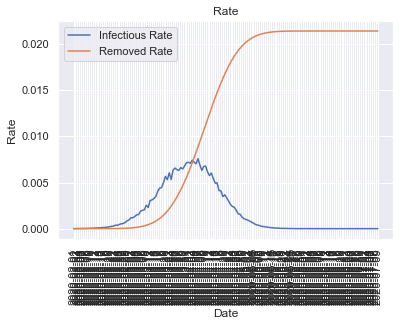

--------------------------------------------------------
first beta=1.6699489020949414e-06, first gamma=0.0
last beta=3.549585078485842e-08, last gamma=0.50562


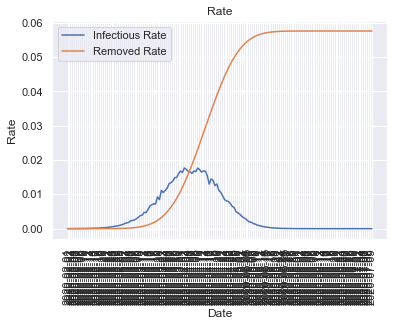

--------------------------------------------------------
first beta=1.9180015147776536e-06, first gamma=0.0
last beta=2.7647047654967986e-08, last gamma=0.50562


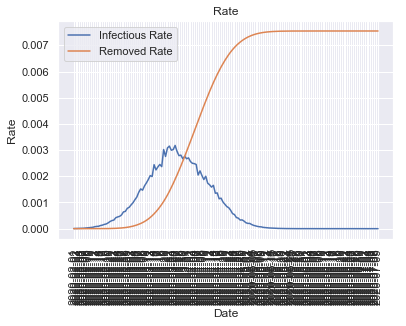

--------------------------------------------------------
first beta=1.5106318732576374e-06, first gamma=0.0
last beta=3.1639052424632274e-08, last gamma=0.50562


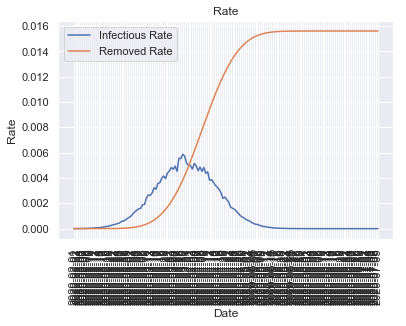

--------------------------------------------------------
first beta=1.5184221948864771e-06, first gamma=0.0
last beta=2.7156763830545944e-08, last gamma=0.50562


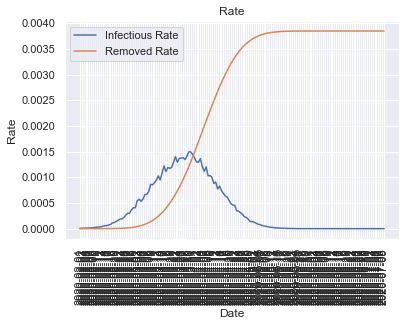

--------------------------------------------------------
first beta=1.6288285747745416e-06, first gamma=0.0
last beta=2.2751864419888384e-08, last gamma=0.50562


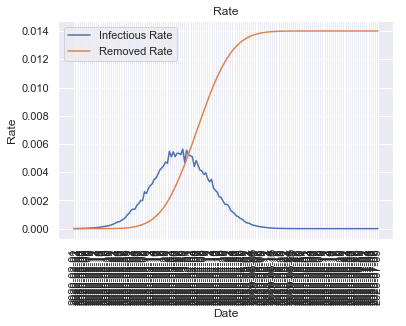

--------------------------------------------------------
first beta=1.7660517927736942e-06, first gamma=0.0
last beta=2.0428553872657213e-08, last gamma=0.50562
--------------------------------------------------------
first beta=1.7088185183898394e-06, first gamma=0.0
last beta=1.8163955926343956e-08, last gamma=0.50562
--------------------------------------------------------
first beta=1.5485359213019828e-06, first gamma=0.0
last beta=2.1673170026906054e-08, last gamma=0.50562
--------------------------------------------------------
first beta=1.8589963195575844e-06, first gamma=0.0
last beta=3.004625510485757e-08, last gamma=0.50562
--------------------------------------------------------
first beta=1.7342690780423537e-06, first gamma=0.0
last beta=2.6911556808710282e-08, last gamma=0.50562
--------------------------------------------------------
first beta=1.6455673971503047e-06, first gamma=0.0
last beta=2.6518745139666236e-08, last gamma=0.50562
-----------------------------------

In [14]:
# Small Noise
for i in range(250):
    # Total population, N.
    N = 200000
    # Initial number of infected and recovered individuals, I0 and R0.
    I, R = 1, 0.0
    # Everyone else, S0, is susceptible to infection initially.
    S = N - I - R
    S_n, I_n, R_n = S, I, R
    t = np.linspace(0, days, days)

    # Dynamic
    beta = random.uniform(1.5e-6, 2.0e-6)
    sir_df = pd.DataFrame(index=[], columns=cols)
    sus, inf, rec= [],[],[]
    sus_n, inf_n, rec_n = [], [], []
    noise = np.random.normal(loc=0, scale=1, size=days)
#     print("--------------------------------------------------------")
#     print("first beta={}, first gamma={}".format(beta, gamma(0)))
    for day in range(days):
        if day % 10 == 0:
            beta = beta * random.uniform(0.66, 0.9)
        sus.append(S)
        inf.append(I)
        rec.append(R)
        sus_n.append(S_n)
        inf_n.append(I_n)
        rec_n.append(R_n)
        S_ = S
        I_ = I
        R_ = R
        S = S_ -beta * S_ * I_
        I = I_ + beta * S_ * I_ - gamma(day) * I_
        R = R_ + gamma(day) * I_
        I_n = max(min(I * (1 - 0.05*noise[day]), N), 0)
        R_n = max(min(R, N), 0)
        S_n = max(min(N - I_n - R_n, N), 0)
    sir_df["confirmed"] = inf
    sir_df["removed"] = rec
    sir_df["susceptible"] = sus
    sir_df["infectious_rate"] = (np.array(inf)/N).tolist()
    sir_df["removed_rate"] = (np.array(rec)/N).tolist()
    sir_df["susceptible_rate"] = (np.array(sus)/N).tolist()
    
    sir_df["confirmed_noise"] = inf_n
    sir_df["removed_noise"] = rec_n
    sir_df["susceptible_noise"] = sus_n
    sir_df["infectious_noise_rate"] = (np.array(inf_n)/N).tolist()
    sir_df["removed_noise_rate"] = (np.array(rec_n)/N).tolist()
    sir_df["susceptible_noise_rate"] = (np.array(sus_n)/N).tolist()
    sir_df["Code"] = "SIR-small-{}".format(i)

    # Rate change
#     sir_df["infectious_rate_change"] = sir_df["infectious_rate"].pct_change()
#     sir_df["infectious_rate_change"] = sir_df["infectious_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
#     sir_df["removed_rate_change"] = sir_df["removed_rate"].pct_change()
#     sir_df["removed_rate_change"] = sir_df["removed_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
#     sir_df["susceptible_rate_change"] = sir_df["susceptible_rate"].pct_change()
#     sir_df["susceptible_rate_change"] = sir_df["susceptible_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    
    # Add Date
    sir_df["Date"] = dates

#     print("last beta={}, last gamma={}".format(beta, gamma(days-1)))
    if i < 10: display_rate(sir_df)
    SIR_df = pd.concat([SIR_df, sir_df])

--------------------------------------------------------
first beta=1.8939074159655588e-06, first gamma=0.0
last beta=4.214564746849379e-08, last gamma=0.50562


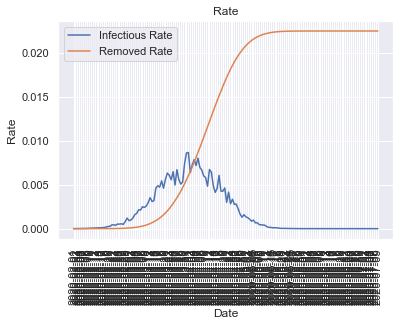

/Users/Skrimson64/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:66: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



--------------------------------------------------------
first beta=1.5175882372332008e-06, first gamma=0.0
last beta=2.4389528022306196e-08, last gamma=0.50562


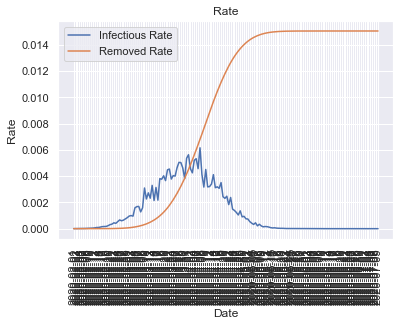

--------------------------------------------------------
first beta=1.5941134687600722e-06, first gamma=0.0
last beta=3.412893829512608e-08, last gamma=0.50562


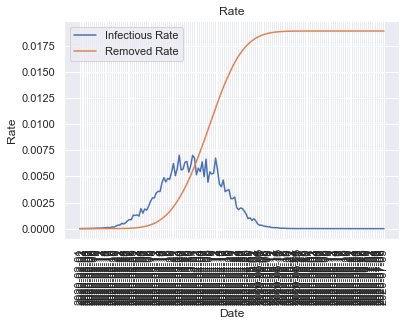

--------------------------------------------------------
first beta=1.8258665053579463e-06, first gamma=0.0
last beta=2.9057030696178298e-08, last gamma=0.50562


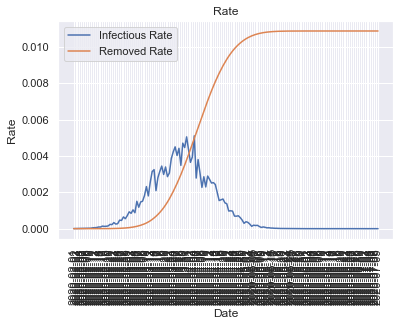

--------------------------------------------------------
first beta=1.9880358211573767e-06, first gamma=0.0
last beta=4.8631578643634634e-08, last gamma=0.50562


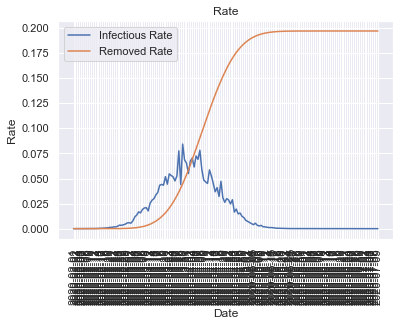

--------------------------------------------------------
first beta=1.8670351645005835e-06, first gamma=0.0
last beta=3.3941763983787026e-08, last gamma=0.50562


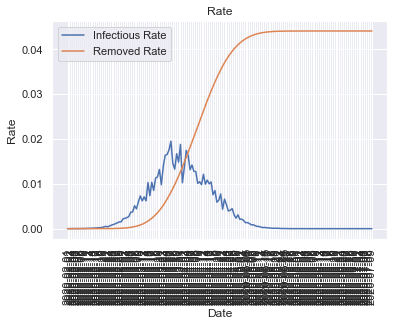

--------------------------------------------------------
first beta=1.5591084859495362e-06, first gamma=0.0
last beta=2.9174013451999493e-08, last gamma=0.50562


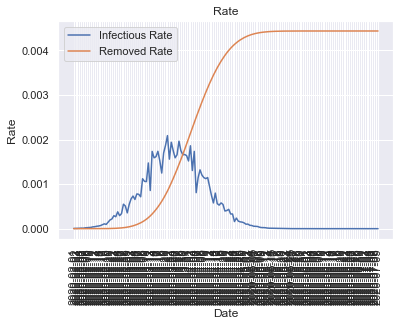

--------------------------------------------------------
first beta=1.76992090096395e-06, first gamma=0.0
last beta=3.641079902627671e-08, last gamma=0.50562


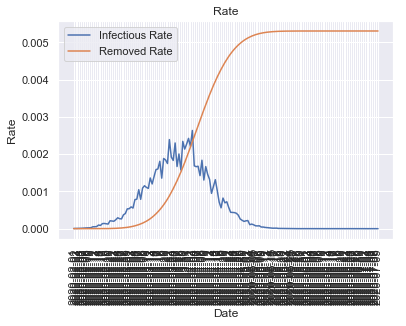

--------------------------------------------------------
first beta=1.7286371914954344e-06, first gamma=0.0
last beta=2.468293266576954e-08, last gamma=0.50562


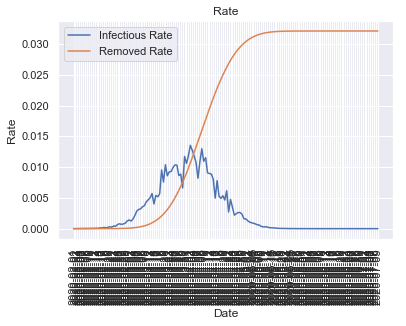

--------------------------------------------------------
first beta=1.5970170017707998e-06, first gamma=0.0
last beta=3.645542596463236e-08, last gamma=0.50562


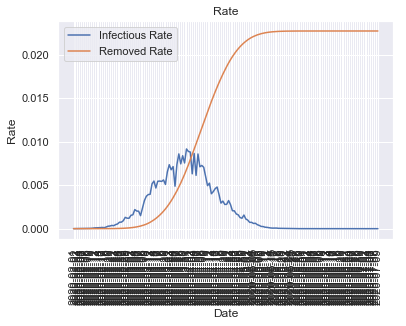

--------------------------------------------------------
first beta=1.7800465582366587e-06, first gamma=0.0
last beta=4.649819455064953e-08, last gamma=0.50562
--------------------------------------------------------
first beta=1.7951207056486932e-06, first gamma=0.0
last beta=5.550640827605123e-08, last gamma=0.50562
--------------------------------------------------------
first beta=1.6082370513606005e-06, first gamma=0.0
last beta=2.597517697849464e-08, last gamma=0.50562
--------------------------------------------------------
first beta=1.7252287612394254e-06, first gamma=0.0
last beta=1.7276186233039786e-08, last gamma=0.50562
--------------------------------------------------------
first beta=1.6688155602926866e-06, first gamma=0.0
last beta=2.4599848144155796e-08, last gamma=0.50562
--------------------------------------------------------
first beta=1.6429162328068863e-06, first gamma=0.0
last beta=3.138705835647537e-08, last gamma=0.50562
--------------------------------------

In [15]:
# Middle Noise
for i in range(250):
    # Total population, N.
    N = 200000
    # Initial number of infected and recovered individuals, I0 and R0.
    I, R = 1, 0.0
    # Everyone else, S0, is susceptible to infection initially.
    S = N - I - R
    S_n, I_n, R_n = S, I, R
    t = np.linspace(0, days, days)

    # Dynamic
    beta = random.uniform(1.5e-6, 2.0e-6)
    sir_df = pd.DataFrame(index=[], columns=cols)
    sus, inf, rec= [],[],[]
    sus_n, inf_n, rec_n = [], [], []
    noise = np.random.normal(loc=0, scale=1, size=days)
#     print("--------------------------------------------------------")
#     print("first beta={}, first gamma={}".format(beta, gamma(0)))
    for day in range(days):
        if day % 10 == 0:
            beta = beta * random.uniform(0.66, 0.9)
        sus.append(S)
        inf.append(I)
        rec.append(R)
        sus_n.append(S_n)
        inf_n.append(I_n)
        rec_n.append(R_n)
        S_ = S
        I_ = I
        R_ = R
        S = S_ -beta * S_ * I_
        I = I_ + beta * S_ * I_ - gamma(day) * I_
        R = R_ + gamma(day) * I_
        I_n = max(min(I * (1 - 0.15*noise[day]), N), 0)
        R_n = max(min(R, N), 0)
        S_n = max(min(N - I_n - R_n, N), 0)
    sir_df["confirmed"] = inf
    sir_df["removed"] = rec
    sir_df["susceptible"] = sus
    sir_df["infectious_rate"] = (np.array(inf)/N).tolist()
    sir_df["removed_rate"] = (np.array(rec)/N).tolist()
    sir_df["susceptible_rate"] = (np.array(sus)/N).tolist()
    
    sir_df["confirmed_noise"] = inf_n
    sir_df["removed_noise"] = rec_n
    sir_df["susceptible_noise"] = sus_n
    sir_df["infectious_noise_rate"] = (np.array(inf_n)/N).tolist()
    sir_df["removed_noise_rate"] = (np.array(rec_n)/N).tolist()
    sir_df["susceptible_noise_rate"] = (np.array(sus_n)/N).tolist()
    sir_df["Code"] = "SIR-middle-{}".format(i)

    # Rate change
#     sir_df["infectious_rate_change"] = sir_df["infectious_rate"].pct_change()
#     sir_df["infectious_rate_change"] = sir_df["infectious_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
#     sir_df["removed_rate_change"] = sir_df["removed_rate"].pct_change()
#     sir_df["removed_rate_change"] = sir_df["removed_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
#     sir_df["susceptible_rate_change"] = sir_df["susceptible_rate"].pct_change()
#     sir_df["susceptible_rate_change"] = sir_df["susceptible_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    
    # Add Date
    sir_df["Date"] = dates

#     print("last beta={}, last gamma={}".format(beta, gamma(days-1)))
    if i < 10: display_rate(sir_df)
    SIR_df = pd.concat([SIR_df, sir_df])

--------------------------------------------------------
first beta=1.5349098492244552e-06, first gamma=0.0
last beta=4.254405633263278e-08, last gamma=0.50562


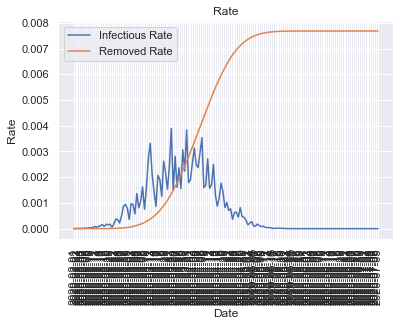

/Users/Skrimson64/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:66: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



--------------------------------------------------------
first beta=1.975920576527742e-06, first gamma=0.0
last beta=2.3504083912616687e-08, last gamma=0.50562


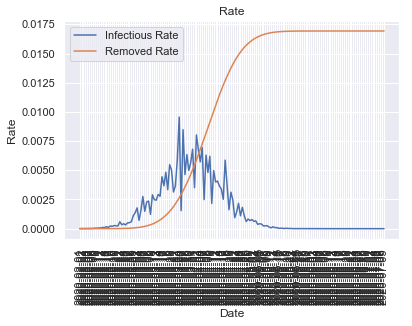

--------------------------------------------------------
first beta=1.648881377436145e-06, first gamma=0.0
last beta=3.83306696409547e-08, last gamma=0.50562


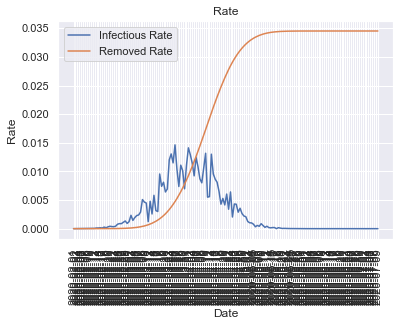

--------------------------------------------------------
first beta=1.9554038770864227e-06, first gamma=0.0
last beta=7.144169165574447e-08, last gamma=0.50562


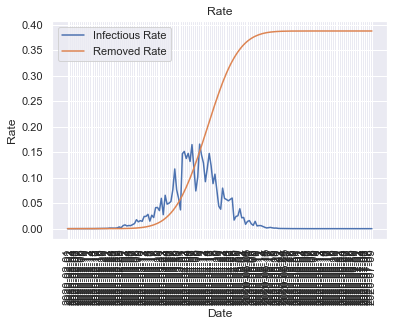

--------------------------------------------------------
first beta=1.9931215042327813e-06, first gamma=0.0
last beta=2.2745262412551484e-08, last gamma=0.50562


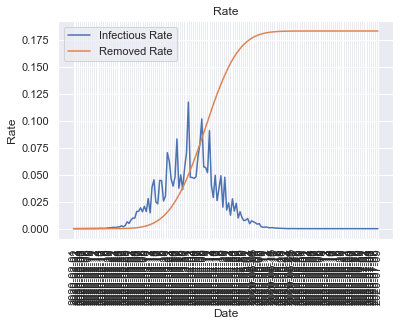

--------------------------------------------------------
first beta=1.6022069269360762e-06, first gamma=0.0
last beta=3.723834747919544e-08, last gamma=0.50562


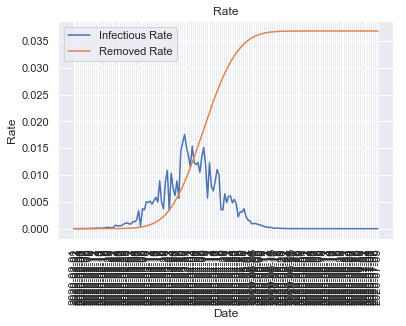

--------------------------------------------------------
first beta=1.756231491000836e-06, first gamma=0.0
last beta=3.474830526284066e-08, last gamma=0.50562


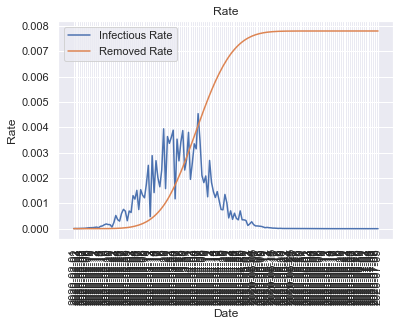

--------------------------------------------------------
first beta=1.6719836050769461e-06, first gamma=0.0
last beta=1.8115778486733494e-08, last gamma=0.50562


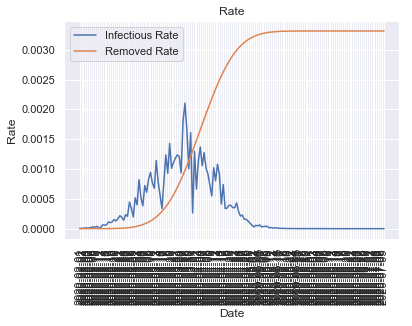

--------------------------------------------------------
first beta=1.8601435305395637e-06, first gamma=0.0
last beta=2.14472340946595e-08, last gamma=0.50562


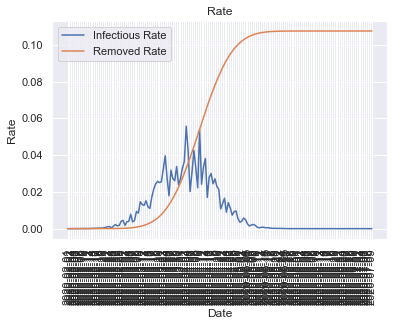

--------------------------------------------------------
first beta=1.7676026242716248e-06, first gamma=0.0
last beta=3.0814144288113387e-08, last gamma=0.50562


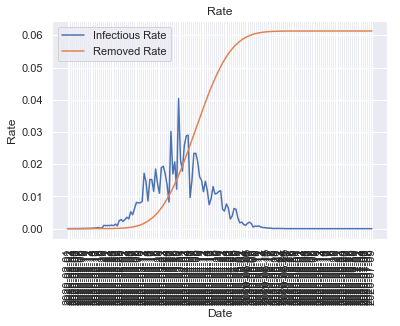

--------------------------------------------------------
first beta=1.831584168277279e-06, first gamma=0.0
last beta=1.7286888514049977e-08, last gamma=0.50562
--------------------------------------------------------
first beta=1.7257263325031232e-06, first gamma=0.0
last beta=5.206235758058796e-08, last gamma=0.50562
--------------------------------------------------------
first beta=1.6739741686505216e-06, first gamma=0.0
last beta=2.631808181133479e-08, last gamma=0.50562
--------------------------------------------------------
first beta=1.8104798784538745e-06, first gamma=0.0
last beta=3.6514703284218704e-08, last gamma=0.50562
--------------------------------------------------------
first beta=1.5244481101392982e-06, first gamma=0.0
last beta=2.0510924631219517e-08, last gamma=0.50562
--------------------------------------------------------
first beta=1.506252101900763e-06, first gamma=0.0
last beta=3.027984811345555e-08, last gamma=0.50562
---------------------------------------

In [16]:
# Large Noise
for i in range(250):
    # Total population, N.
    N = 200000
    # Initial number of infected and recovered individuals, I0 and R0.
    I, R = 1, 0.0
    # Everyone else, S0, is susceptible to infection initially.
    S = N - I - R
    S_n, I_n, R_n = S, I, R
    t = np.linspace(0, days, days)

    # Dynamic
    beta = random.uniform(1.5e-6, 2.0e-6)
    sir_df = pd.DataFrame(index=[], columns=cols)
    sus, inf, rec= [],[],[]
    sus_n, inf_n, rec_n = [], [], []
    noise = np.random.normal(loc=0, scale=1, size=days)
#     print("--------------------------------------------------------")
#     print("first beta={}, first gamma={}".format(beta, gamma(0)))
    for day in range(days):
        if day % 10 == 0:
            beta = beta * random.uniform(0.66, 0.9)
        sus.append(S)
        inf.append(I)
        rec.append(R)
        sus_n.append(S_n)
        inf_n.append(I_n)
        rec_n.append(R_n)
        S_ = S
        I_ = I
        R_ = R
        S = S_ -beta * S_ * I_
        I = I_ + beta * S_ * I_ - gamma(day) * I_
        R = R_ + gamma(day) * I_
        I_n = max(min(I * (1 - 0.3*noise[day]), N), 0)
        R_n = max(min(R, N), 0)
        S_n = max(min(N - I_n - R_n, N), 0)
    sir_df["confirmed"] = inf
    sir_df["removed"] = rec
    sir_df["susceptible"] = sus
    sir_df["infectious_rate"] = (np.array(inf)/N).tolist()
    sir_df["removed_rate"] = (np.array(rec)/N).tolist()
    sir_df["susceptible_rate"] = (np.array(sus)/N).tolist()
    
    sir_df["confirmed_noise"] = inf_n
    sir_df["removed_noise"] = rec_n
    sir_df["susceptible_noise"] = sus_n
    sir_df["infectious_noise_rate"] = (np.array(inf_n)/N).tolist()
    sir_df["removed_noise_rate"] = (np.array(rec_n)/N).tolist()
    sir_df["susceptible_noise_rate"] = (np.array(sus_n)/N).tolist()
    sir_df["Code"] = "SIR-large-{}".format(i)

    # Rate change
#     sir_df["infectious_rate_change"] = sir_df["infectious_rate"].pct_change()
#     sir_df["infectious_rate_change"] = sir_df["infectious_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
#     sir_df["removed_rate_change"] = sir_df["removed_rate"].pct_change()
#     sir_df["removed_rate_change"] = sir_df["removed_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
#     sir_df["susceptible_rate_change"] = sir_df["susceptible_rate"].pct_change()
#     sir_df["susceptible_rate_change"] = sir_df["susceptible_rate_change"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    
    # Add Date
    sir_df["Date"] = dates

#     print("last beta={}, last gamma={}".format(beta, gamma(days-1)))
    if i < 10: display_rate(sir_df)
    SIR_df = pd.concat([SIR_df, sir_df])

In [17]:
# train_df = new_df.copy()
train_df = SIR_df.copy()
train_df.tail()

,Code,Date,confirmed,confirmed_noise,infectious_noise_rate,infectious_rate,removed,removed_noise,removed_noise_rate,removed_rate,susceptible,susceptible_noise,susceptible_noise_rate,susceptible_rate
155,SIR-large-249,2020-07-05,5.754564e-09,7.395232e-09,3.697616e-14,2.877282e-14,1444.598323,1444.598323,0.007223,0.007223,198555.401677,198555.401677,0.992777,0.992777
156,SIR-large-249,2020-07-06,3.020118e-09,2.867932e-09,1.433966e-14,1.510059e-14,1444.598323,1444.598323,0.007223,0.007223,198555.401677,198555.401677,0.992777,0.992777
157,SIR-large-249,2020-07-07,1.566237e-09,1.420853e-09,7.104263e-15,7.831186e-15,1444.598323,1444.598323,0.007223,0.007223,198555.401677,198555.401677,0.992777,0.992777
158,SIR-large-249,2020-07-08,8.024480e-10,8.789617e-10,4.394809e-15,4.012240e-15,1444.598323,1444.598323,0.007223,0.007223,198555.401677,198555.401677,0.992777,0.992777
159,SIR-large-249,2020-07-09,4.060719e-10,5.062419e-10,2.531210e-15,2.030359e-15,1444.598323,1444.598323,0.007223,0.007223,198555.401677,198555.401677,0.992777,0.992777


# 3. Model

In [18]:
days_in_sequence = 21
output_days = 7

sequence_length = days_in_sequence - 1
training_percentage = 0.9
temp_dim = 3

In [19]:
#temporal input branch
temporal_input_layer = Input(shape=(sequence_length,temp_dim))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2)(temporal_input_layer)

#demographic input branch
# demographic_input_layer = Input(shape=(dem_dim,))
# demographic_dense = layers.Dense(16)(demographic_input_layer)
# demographic_dropout = layers.Dropout(0.2)(demographic_dense)

#cases output branch
rnn_c = layers.LSTM(32)(main_rnn_layer)
# merge_c = layers.Concatenate(axis=-1)([rnn_c,demographic_dropout])
dense_c = layers.Dense(16)(rnn_c)
dropout_c = layers.Dropout(0.2)(dense_c)
output_c = layers.Dense(7)(dropout_c) #activation=layers.LeakyReLU(alpha=0.1)
cases = layers.LeakyReLU(alpha=0.1,name="infectious")(output_c)

#fatality output branch
rnn_f = layers.LSTM(32)(main_rnn_layer)
# merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dropout])
dense_f = layers.Dense(16)(rnn_f)
dropout_f = layers.Dropout(0.2)(dense_f)
output_f = layers.Dense(7)(dropout_f)
fatalities = layers.LeakyReLU(alpha=0.1, name="removed")(output_f)


model = Model([temporal_input_layer], [cases,fatalities])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 3)        0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 20, 64)       17408       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 32)           12416       lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 32)           12416       lstm[0][0]                       
__________________________________________________________________________________________________
dense (Den

In [20]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.6), #patience=4  #EarlyStopping(monitor='val_loss', patience=20)
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.mean_squared_logarithmic_error,tf.keras.losses.mean_squared_logarithmic_error], optimizer="adam")

In [21]:
# Creating train input from DataFrames No Noise
# train_country = ["KOR", "TWA", "THA", "ITA", "ISL", "DNK"]
# train_df = train_df.query("Code in {}".format(train_country))

trend_list = []

# for code in train_df.Code.unique():
for i in range(250):
    code = "SIR-small-{}".format(i)
    country_df = train_df.query(f"Code=='{code}'")
    # Added a quick hack to double the number of sequences
    # Warning: This will later create a minor leakage from the training set into the validation set.
    for i in range(0,len(country_df),int(days_in_sequence/2)):
        if i+days_in_sequence<=len(country_df):
            
            #prepare rate inputs, use rates with noise
            infectious_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].infectious_rate]
            removed_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].removed_rate]
            susceptible_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].susceptible_rate] 

            #prepare outputs, use original rates
            expected_infectious_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].infectious_rate]
            expected_removed_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].removed_rate]

            trend_list.append({ "infectious_rate_trend":infectious_rate_trend,
                                "removed_rate_trend":removed_rate_trend,
                                "susceptible_rate_trend":susceptible_rate_trend,
                                "expected_infectious_rate":expected_infectious_rate,
                                "expected_removed_rate":expected_removed_rate})
trend_df = pd.DataFrame(trend_list)

trend_df["temporal_inputs"] = [np.asarray([trends["infectious_rate_trend"], trends["removed_rate_trend"], trends["susceptible_rate_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,temp_dim,sequence_length)),(0,2,1) )).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_infectious_rate"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_removed_rate"]]).astype(np.float32)

X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,temp_dim,sequence_length)),(0,2,1)) ).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_infectious_rate"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_removed_rate"]]).astype(np.float32)

In [22]:
history = model.fit([X_temporal_train], [Y_cases_train, Y_fatalities_train], 
          epochs = 50, 
          batch_size = 16, 
          validation_data=([X_temporal_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)
loss = history.history['loss']
infectious_loss = history.history['infectious_loss']
removed_loss = history.history['removed_loss']
val_loss = history.history['val_loss']
val_infectious_loss = history.history['val_infectious_loss']
val_removed_loss = history.history['val_removed_loss']

Train on 3150 samples, validate on 350 samples
Epoch 1/50
3150/3150 [==============================] - 19s 6ms/step - loss: 0.0017 - infectious_loss: 1.7342e-04 - removed_loss: 0.0015 - val_loss: 6.1349e-04 - val_infectious_loss: 9.7429e-05 - val_removed_loss: 5.1606e-04
Epoch 2/50
3150/3150 [==============================] - 14s 4ms/step - loss: 4.8680e-04 - infectious_loss: 1.5020e-04 - removed_loss: 3.3661e-04 - val_loss: 1.5127e-04 - val_infectious_loss: 9.7429e-05 - val_removed_loss: 5.3844e-05
Epoch 3/50
3150/3150 [==============================] - 12s 4ms/step - loss: 3.2157e-04 - infectious_loss: 1.5007e-04 - removed_loss: 1.7150e-04 - val_loss: 1.0388e-04 - val_infectious_loss: 9.7429e-05 - val_removed_loss: 6.4499e-06
Epoch 4/50
3150/3150 [==============================] - 11s 3ms/step - loss: 2.8594e-04 - infectious_loss: 1.5016e-04 - removed_loss: 1.3579e-04 - val_loss: 1.4015e-04 - val_infectious_loss: 9.7429e-05 - val_removed_loss: 4.2719e-05
Epoch 5/50
3150/3150 [=======

In [23]:
# Creating train input from DataFrames Small Noise
# train_country = ["KOR", "TWA", "THA", "ITA", "ISL", "DNK"]
# train_df = train_df.query("Code in {}".format(train_country))
days_in_sequence = 21
output_days = 7

trend_list = []

# for code in train_df.Code.unique():
for i in range(250):
    code = "SIR-small-{}".format(i)
    country_df = train_df.query(f"Code=='{code}'")
    # Added a quick hack to double the number of sequences
    # Warning: This will later create a minor leakage from the training set into the validation set.
    for i in range(0,len(country_df),int(days_in_sequence/2)):
        if i+days_in_sequence<=len(country_df):
            
            #prepare rate inputs, use rates with noise
            infectious_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].infectious_noise_rate]
            removed_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].removed_noise_rate]
            susceptible_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].susceptible_noise_rate] 

            #prepare outputs, use original rates
            expected_infectious_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].infectious_rate]
            expected_removed_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].removed_rate]

            trend_list.append({ "infectious_rate_trend":infectious_rate_trend,
                                "removed_rate_trend":removed_rate_trend,
                                "susceptible_rate_trend":susceptible_rate_trend,
                                "expected_infectious_rate":expected_infectious_rate,
                                "expected_removed_rate":expected_removed_rate})
trend_df = pd.DataFrame(trend_list)

trend_df["temporal_inputs"] = [np.asarray([trends["infectious_rate_trend"], trends["removed_rate_trend"], trends["susceptible_rate_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

sequence_length = days_in_sequence - 1
training_percentage = 0.9
temp_dim = 3

training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,temp_dim,sequence_length)),(0,2,1) )).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_infectious_rate"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_removed_rate"]]).astype(np.float32)

X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,temp_dim,sequence_length)),(0,2,1)) ).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_infectious_rate"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_removed_rate"]]).astype(np.float32)

In [24]:
history = model.fit([X_temporal_train], [Y_cases_train, Y_fatalities_train], 
          initial_epoch=50,
          epochs = 100,  
          batch_size = 16, 
          validation_data=([X_temporal_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)
loss.extend(history.history['loss'])
infectious_loss.extend(history.history['infectious_loss'])
removed_loss.extend(history.history['removed_loss'])
val_loss.extend(history.history['val_loss'])
val_infectious_loss.extend(history.history['val_infectious_loss'])
val_removed_loss.extend(history.history['val_removed_loss'])

Train on 3150 samples, validate on 350 samples
Epoch 51/100
3150/3150 [==============================] - 9s 3ms/step - loss: 4.4522e-05 - infectious_loss: 5.3521e-06 - removed_loss: 3.9170e-05 - val_loss: 4.1996e-06 - val_infectious_loss: 1.8361e-06 - val_removed_loss: 2.3635e-06
Epoch 52/100
3150/3150 [==============================] - 9s 3ms/step - loss: 4.6545e-05 - infectious_loss: 5.0021e-06 - removed_loss: 4.1543e-05 - val_loss: 6.0345e-06 - val_infectious_loss: 1.8027e-06 - val_removed_loss: 4.2318e-06
Epoch 53/100
3150/3150 [==============================] - 9s 3ms/step - loss: 4.3409e-05 - infectious_loss: 5.3527e-06 - removed_loss: 3.8057e-05 - val_loss: 3.6060e-06 - val_infectious_loss: 1.3049e-06 - val_removed_loss: 2.3011e-06
Epoch 54/100
3150/3150 [==============================] - 9s 3ms/step - loss: 4.1587e-05 - infectious_loss: 4.8666e-06 - removed_loss: 3.6721e-05 - val_loss: 5.3948e-06 - val_infectious_loss: 1.3577e-06 - val_removed_loss: 4.0371e-06
Epoch 55/100
3150

In [25]:
# Create middle noise data
days_in_sequence = 21
output_days = 7

trend_list = []

# for code in train_df.Code.unique():
for i in range(250):
    code = "SIR-middle-{}".format(i)
    country_df = train_df.query(f"Code=='{code}'")
    # Added a quick hack to double the number of sequences
    # Warning: This will later create a minor leakage from the training set into the validation set.
    for i in range(0,len(country_df),int(days_in_sequence/2)):
        if i+days_in_sequence<=len(country_df):
            
            #prepare rate inputs, use rates with noise
            infectious_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].infectious_noise_rate]
            removed_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].removed_noise_rate]
            susceptible_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].susceptible_noise_rate] 

            #prepare outputs, use original rates
            expected_infectious_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].infectious_rate]
            expected_removed_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].removed_rate]

            trend_list.append({ "infectious_rate_trend":infectious_rate_trend,
                                "removed_rate_trend":removed_rate_trend,
                                "susceptible_rate_trend":susceptible_rate_trend,
                                "expected_infectious_rate":expected_infectious_rate,
                                "expected_removed_rate":expected_removed_rate})
trend_df = pd.DataFrame(trend_list)

trend_df["temporal_inputs"] = [np.asarray([trends["infectious_rate_trend"], trends["removed_rate_trend"], trends["susceptible_rate_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)
print(len(trend_df))
trend_df.head()

sequence_length = days_in_sequence - 1
training_percentage = 0.9

temp_dim = 3

training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,temp_dim,sequence_length)),(0,2,1) )).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_infectious_rate"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_removed_rate"]]).astype(np.float32)

X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,temp_dim,sequence_length)),(0,2,1)) ).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_infectious_rate"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_removed_rate"]]).astype(np.float32)

3500


In [26]:
history = model.fit([X_temporal_train], [Y_cases_train, Y_fatalities_train],
          initial_epoch=100,
          epochs = 150, 
          batch_size = 16, 
          validation_data=([X_temporal_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)
loss.extend(history.history['loss'])
infectious_loss.extend(history.history['infectious_loss'])
removed_loss.extend(history.history['removed_loss'])
val_loss.extend(history.history['val_loss'])
val_infectious_loss.extend(history.history['val_infectious_loss'])
val_removed_loss.extend(history.history['val_removed_loss'])

Train on 3150 samples, validate on 350 samples
Epoch 101/150
3150/3150 [==============================] - 9s 3ms/step - loss: 4.4850e-05 - infectious_loss: 6.2783e-06 - removed_loss: 3.8572e-05 - val_loss: 3.4481e-06 - val_infectious_loss: 2.5464e-06 - val_removed_loss: 9.0171e-07
Epoch 102/150
3150/3150 [==============================] - 9s 3ms/step - loss: 3.8513e-05 - infectious_loss: 6.8705e-06 - removed_loss: 3.1642e-05 - val_loss: 3.7097e-06 - val_infectious_loss: 2.5237e-06 - val_removed_loss: 1.1860e-06
Epoch 103/150
3150/3150 [==============================] - 10s 3ms/step - loss: 4.4907e-05 - infectious_loss: 7.3224e-06 - removed_loss: 3.7585e-05 - val_loss: 4.1242e-06 - val_infectious_loss: 2.5331e-06 - val_removed_loss: 1.5911e-06
Epoch 104/150
3150/3150 [==============================] - 9s 3ms/step - loss: 4.2445e-05 - infectious_loss: 6.6539e-06 - removed_loss: 3.5791e-05 - val_loss: 4.2394e-06 - val_infectious_loss: 2.6628e-06 - val_removed_loss: 1.5766e-06
Epoch 105/15

In [27]:
# Create large noise data
days_in_sequence = 21
output_days = 7

trend_list = []

# for code in train_df.Code.unique():
for i in range(250):
    code = "SIR-large-{}".format(i)
    country_df = train_df.query(f"Code=='{code}'")
    # Added a quick hack to double the number of sequences
    # Warning: This will later create a minor leakage from the training set into the validation set.
    for i in range(0,len(country_df),int(days_in_sequence/2)):
        if i+days_in_sequence<=len(country_df):
            
            #prepare rate inputs, use rates with noise
            infectious_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].infectious_noise_rate]
            removed_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].removed_noise_rate]
            susceptible_rate_trend = [float(x) for x in country_df[i:i+days_in_sequence-1].susceptible_noise_rate] 

            #prepare outputs, use original rates
            expected_infectious_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].infectious_rate]
            expected_removed_rate = [float(x) for x in country_df.iloc[i+days_in_sequence-1:i+days_in_sequence-1+output_days].removed_rate]

            trend_list.append({ "infectious_rate_trend":infectious_rate_trend,
                                "removed_rate_trend":removed_rate_trend,
                                "susceptible_rate_trend":susceptible_rate_trend,
                                "expected_infectious_rate":expected_infectious_rate,
                                "expected_removed_rate":expected_removed_rate})
trend_df = pd.DataFrame(trend_list)

trend_df["temporal_inputs"] = [np.asarray([trends["infectious_rate_trend"], trends["removed_rate_trend"], trends["susceptible_rate_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)
print(len(trend_df))
trend_df.head()

sequence_length = days_in_sequence - 1
training_percentage = 0.9

temp_dim = 3

training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,temp_dim,sequence_length)),(0,2,1) )).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_infectious_rate"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_removed_rate"]]).astype(np.float32)

X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,temp_dim,sequence_length)),(0,2,1)) ).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_infectious_rate"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_removed_rate"]]).astype(np.float32)

3500


In [28]:
history = model.fit([X_temporal_train], [Y_cases_train, Y_fatalities_train],
          initial_epoch=150,
          epochs = 200, 
          batch_size = 16, 
          validation_data=([X_temporal_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)
loss.extend(history.history['loss'])
infectious_loss.extend(history.history['infectious_loss'])
removed_loss.extend(history.history['removed_loss'])
val_loss.extend(history.history['val_loss'])
val_infectious_loss.extend(history.history['val_infectious_loss'])
val_removed_loss.extend(history.history['val_removed_loss'])

Train on 3150 samples, validate on 350 samples
Epoch 151/200
3150/3150 [==============================] - 9s 3ms/step - loss: 8.1876e-05 - infectious_loss: 1.5130e-05 - removed_loss: 6.6746e-05 - val_loss: 1.4185e-05 - val_infectious_loss: 1.1462e-05 - val_removed_loss: 2.7230e-06
Epoch 152/200
3150/3150 [==============================] - 9s 3ms/step - loss: 6.4907e-05 - infectious_loss: 1.5823e-05 - removed_loss: 4.9084e-05 - val_loss: 1.4350e-05 - val_infectious_loss: 1.1556e-05 - val_removed_loss: 2.7942e-06
Epoch 153/200
3150/3150 [==============================] - 9s 3ms/step - loss: 6.6190e-05 - infectious_loss: 1.3446e-05 - removed_loss: 5.2744e-05 - val_loss: 1.4383e-05 - val_infectious_loss: 1.1636e-05 - val_removed_loss: 2.7475e-06
Epoch 154/200
3150/3150 [==============================] - 9s 3ms/step - loss: 6.1587e-05 - infectious_loss: 1.4455e-05 - removed_loss: 4.7132e-05 - val_loss: 1.4502e-05 - val_infectious_loss: 1.1614e-05 - val_removed_loss: 2.8886e-06
Epoch 155/200

# 4. Performance during training

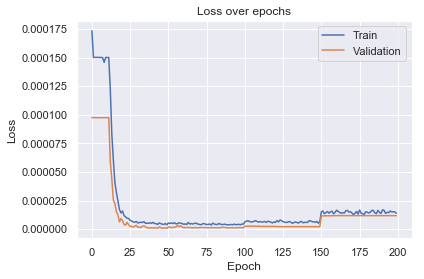

In [29]:
plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

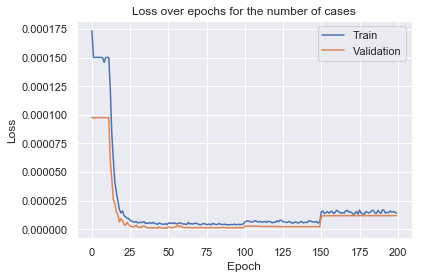

In [30]:
plt.plot(infectious_loss)
plt.plot(val_infectious_loss)
plt.title('Loss over epochs for the number of cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

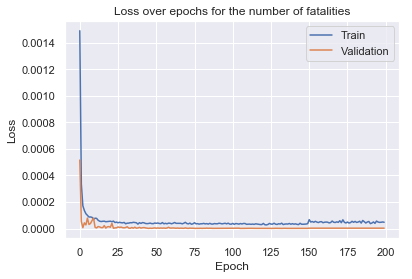

In [31]:
plt.plot(removed_loss)
plt.plot(val_removed_loss)
plt.title('Loss over epochs for the number of fatalities')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

# 5. Generate predictions using the model

In [32]:
model.load_weights("best_model.h5")
predictions = model.predict([X_temporal_test])

In [33]:
display_limit = 30
for inputs, pred_cases, exp_cases, pred_fatalities, exp_fatalities in zip(X_temporal_test,predictions[0][:display_limit], Y_cases_test[:display_limit], predictions[1][:display_limit], Y_fatalities_test[:display_limit]):
    print("================================================")
    print(inputs)
    print("Expected infectious rate:", exp_cases)
    print("Prediction:", pred_cases)
    print("Expected removed rate:", exp_fatalities)
    print("Prediction:", pred_fatalities)

[[0.04045457 0.02345946 0.93608594]
 [0.04433002 0.02569178 0.9299782 ]
 [0.04503177 0.02800311 0.9269651 ]
 [0.03302665 0.03038878 0.9365846 ]
 [0.04064196 0.03284338 0.9265147 ]
 [0.02925239 0.03536087 0.9353867 ]
 [0.02571949 0.03793453 0.936346  ]
 [0.03090351 0.04055707 0.92853945]
 [0.02940696 0.04322063 0.9273724 ]
 [0.03622788 0.04591689 0.9178552 ]
 [0.03233563 0.0486371  0.91902727]
 [0.02736296 0.0513722  0.9212648 ]
 [0.02735147 0.05406717 0.91858137]
 [0.03361376 0.05671348 0.90967274]
 [0.01614999 0.05930298 0.924547  ]
 [0.00509841 0.06182799 0.9330736 ]
 [0.01216631 0.06428137 0.92355233]
 [0.01701721 0.06665663 0.91632617]
 [0.02242976 0.0689479  0.9086223 ]
 [0.00525927 0.07115005 0.92359066]]
Expected infectious rate: [0.01571534 0.01444325 0.01322707 0.01206972 0.01097341 0.00993971
 0.00896952]
Prediction: [ 6.4297626e-03  4.7447444e-03  2.4253838e-03  5.0688256e-04
 -5.1805935e-05 -2.7038349e-04 -4.6970005e-04]
Expected removed rate: [0.07325871 0.07527027 0.07716

# 6. Apply the model to predict future trends

In [34]:
#Will retrieve the number of cases and fatalities for the past 14
def build_inputs_for_date_code(code, date, gdf):
    start_date = date - timedelta(days=days_in_sequence-1) # input start date
    end_date = date - timedelta(days=1) # input end date
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    tdf = gdf[(gdf["Code"] == code) & (gdf["Date"] >= str_start_date) & (gdf["Date"] <= str_end_date)]

    
    #preparing the temporal inputs
    temporal_input_data = np.transpose(np.reshape(np.asarray([tdf["infectious_noise_rate"],
                                                 tdf["removed_noise_rate"],
                                                 tdf["susceptible_noise_rate"]]),
                                     (3,sequence_length)), (1,0) ).astype(np.float32)
    
    return [np.array([temporal_input_data])]

In [35]:
#Take a dataframe in input, will do the predictions and return the dataframe with extra rows
#containing the predictions
def predict_for_code(code, pdf, gdf):
    tdf = pdf[pdf["Code"]==code]
    # begin_prediction = "2020-03-26"
    begin_prediction = tdf.iloc[0]["Date"]
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d") + timedelta(days_in_sequence) #start of the prediction date
    print("prediction start date: {}".format(datetime.strftime(start_date, "%Y-%m-%d")))
    # end_prediction = "2020-04-15"
    end_prediction = tdf.iloc[-1]["Date"]
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days+1, output_days+1)]
    for date in date_list:
        date_until = date + timedelta(days=output_days-1)
        input_data = build_inputs_for_date_code(code, date, gdf)
        result = model.predict(input_data)

        # add predicted results
        # pdf.loc[(pdf["Code"] == code) & (pdf["Date"] == date.strftime("%Y-%m-%d")), ["infectious_rate", "removed_rate"]] = [result[0][0][0], result[1][0][0]]
        try:
            pdf.loc[(pdf["Code"] == code) & (pdf["Date"] >= date.strftime("%Y-%m-%d")) & (pdf["Date"] <= date_until.strftime("%Y-%m-%d")), ["infectious_noise_rate"]] = result[0][0].tolist()
            pdf.loc[(pdf["Code"] == code) & (pdf["Date"] >= date.strftime("%Y-%m-%d")) & (pdf["Date"] <= date_until.strftime("%Y-%m-%d")), ["removed_noise_rate"]] = result[1][0].tolist()
        except:
            print(date)
            print(result)
        
    return pdf

In [36]:
#Will retrieve the number of cases and fatalities for the past 14
def build_inputs_for_date(code, date, gdf):
    start_date = date - timedelta(days=days_in_sequence-1) # input start date
    end_date = date - timedelta(days=1) # input end date
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    tdf = gdf[(gdf["Code"] == code) & (gdf["Date"] >= str_start_date) & (gdf["Date"] <= str_end_date)]

    
    #preparing the temporal inputs
    temporal_input_data = np.transpose(np.reshape(np.asarray([tdf["infectious_rate"],
                                                 tdf["removed_rate"],
                                                 tdf["susceptible_rate"]]),
                                     (3,sequence_length)), (1,0) ).astype(np.float32)
    
    return [np.array([temporal_input_data])]

In [37]:
#Take a dataframe in input, will do the predictions and return the dataframe with extra rows
#containing the predictions
def predict_for_region(code, pdf, gdf):
    tdf = pdf[pdf["Code"]==code]
    # begin_prediction = "2020-03-26"
    begin_prediction = tdf.iloc[0]["Date"]
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d") + timedelta(days_in_sequence) #start of the prediction date
    print("prediction start date: {}".format(datetime.strftime(start_date, "%Y-%m-%d")))
    # end_prediction = "2020-04-15"
    end_prediction = tdf.iloc[-1]["Date"]
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days+1, output_days+1)]
    for date in date_list:
        date_until = date + timedelta(days=output_days-1)
        input_data = build_inputs_for_date(code, date, gdf)
        result = model.predict(input_data)

        # add predicted results
        # pdf.loc[(pdf["Code"] == code) & (pdf["Date"] == date.strftime("%Y-%m-%d")), ["infectious_rate", "removed_rate"]] = [result[0][0][0], result[1][0][0]]
        try:
            pdf.loc[(pdf["Code"] == code) & (pdf["Date"] >= date.strftime("%Y-%m-%d")) & (pdf["Date"] <= date_until.strftime("%Y-%m-%d")), ["infectious_rate"]] = result[0][0].tolist()
            pdf.loc[(pdf["Code"] == code) & (pdf["Date"] >= date.strftime("%Y-%m-%d")) & (pdf["Date"] <= date_until.strftime("%Y-%m-%d")), ["removed_rate"]] = result[1][0].tolist()
        except:
            print(date)
            print(result)
        
    return pdf

In [38]:
# Predictions for SIR
pdf = SIR_df.copy()
pdf["infectious_noise_rate"] = np.nan
pdf["removed_noise_rate"] = np.nan
gdf = SIR_df.copy()

for code in range(81, 100):
    pdf = predict_for_code("SIR-small-{}".format(code), pdf, gdf)
pdf.to_csv("./predictions_SIR.csv")

# Predictions for countries
test_country = ["KOR", "ITA", "FRA", "DEU", "ISL", "DNK", "THA", "TWN"]
cpdf = new_df.copy().query("Code in {}".format(test_country)) # prediction data frame
cpdf["infectious_rate"] = np.nan
cpdf["removed_rate"] = np.nan
cgdf = new_df.copy().query("Code in {}".format(test_country))

for code in test_country:
    cpdf = predict_for_region(code, cpdf, cgdf)
cpdf.to_csv("./predictions_countries.csv")

prediction start date: 2020-02-22
2020-07-07 00:00:00
[array([[-1.0910481e-04, -7.0642585e-05, -9.9274381e-05, -9.0081150e-05,
        -7.5965094e-05, -1.1333232e-04, -1.1990946e-04]], dtype=float32), array([[0.02806632, 0.02825189, 0.02845341, 0.02852298, 0.02868888,
        0.02876355, 0.02890684]], dtype=float32)]
prediction start date: 2020-02-22
2020-07-07 00:00:00
[array([[-0.00022492, -0.00016846, -0.00024189, -0.00023133, -0.00021343,
        -0.00029066, -0.00033181]], dtype=float32), array([[0.06308575, 0.06337176, 0.06360215, 0.06372254, 0.06395457,
        0.06392692, 0.06401037]], dtype=float32)]
prediction start date: 2020-02-22
2020-07-07 00:00:00
[array([[-5.2126965e-05, -2.2268110e-05, -2.9454148e-05, -2.1282491e-05,
        -8.9841433e-06, -2.6831636e-05, -1.7353381e-05]], dtype=float32), array([[0.01242738, 0.01256891, 0.01276207, 0.01280816, 0.01294496,
        0.01307185, 0.01325542]], dtype=float32)]
prediction start date: 2020-02-22
2020-07-07 00:00:00
[array([[-

# 7. Outputs: Observing the curves

In [39]:
dates = gdf.Date.unique()
dates = sorted(dates)
last_date = dates[-1]
print(last_date)

2020-07-09


In [40]:
def display_comparison_SIR(code, pdf, groundtruth_df):
    groundtruth = groundtruth_df[(groundtruth_df["Code"]==code) & (groundtruth_df["Date"]>="2020-02-07")]
    prediction = pdf[(pdf["Code"] == code) & (pdf["Date"] >= "2020-02-07")]
    
    plt.plot(groundtruth.infectious_noise_rate.values)
    plt.plot(groundtruth.infectious_rate.values)
    plt.plot(prediction.infectious_noise_rate.values)
    plt.title("Comparison between the actual data and our predictions for the number of cases")
    plt.ylabel('Number of cases')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth with noise', 'Groundtruth', 'Prediction'], loc='best')
    plt.show()
    
    plt.plot(groundtruth.removed_noise_rate.values)
    plt.plot(groundtruth.removed_rate.values)
    plt.plot(prediction.removed_noise_rate.values)
    plt.title("Comparison between the actual data and our predictions for the number of fatalities")
    plt.ylabel('Number of fatalities')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth with noise', 'Groundtruth', 'Prediction'], loc='best')
    plt.show()

In [41]:
def display_comparison_region(code, cpdf, groundtruth_df):
    groundtruth = groundtruth_df[(groundtruth_df["Code"]==code) & (groundtruth_df["Date"]>="2020-02-07")]
    prediction = cpdf[(cpdf["Code"] == code) & (cpdf["Date"] >= "2020-02-07")]
    
    plt.plot(groundtruth.infectious_rate.values)
    plt.plot(prediction.infectious_rate.values)
    plt.title("Comparison between the actual data and our predictions for the number of cases")
    plt.ylabel('Number of cases')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()
    
    plt.plot(groundtruth.removed_rate.values)
    plt.plot(prediction.removed_rate.values)
    plt.title("Comparison between the actual data and our predictions for the number of fatalities")
    plt.ylabel('Number of fatalities')
    plt.xlabel('Date')
    plt.xticks(range(len(prediction.Date.values)),prediction.Date.values,rotation='vertical')
    plt.legend(['Groundtruth', 'Prediction'], loc='best')
    plt.show()

------------------------------SIR-small-81---------------------------------


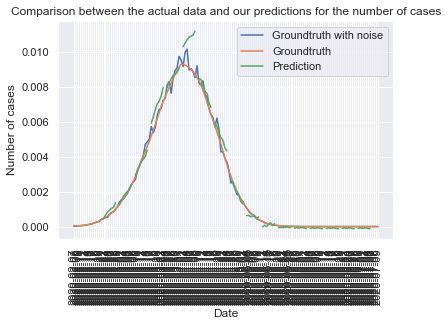

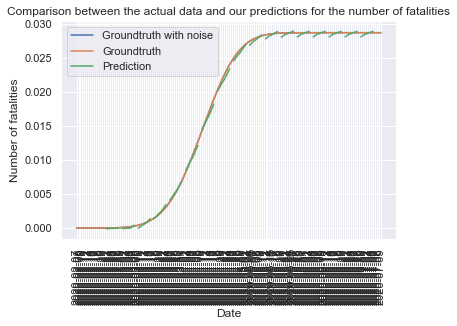

------------------------------SIR-small-82---------------------------------


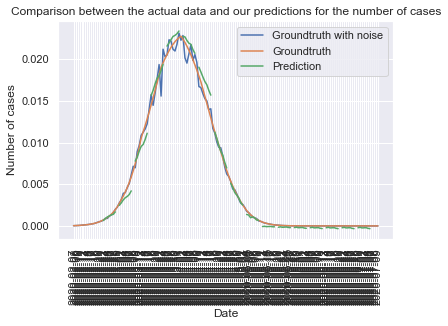

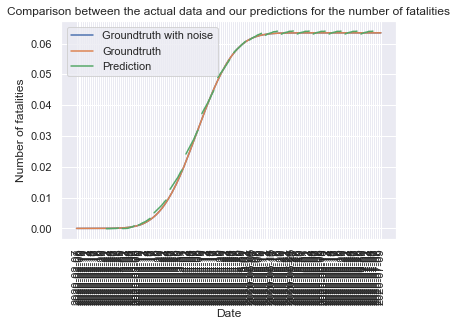

------------------------------SIR-small-83---------------------------------


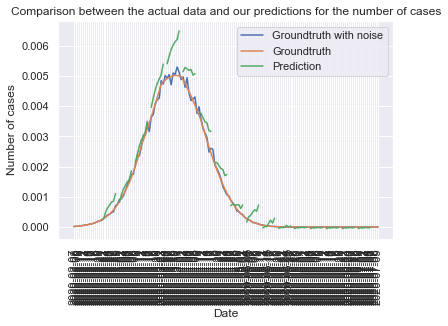

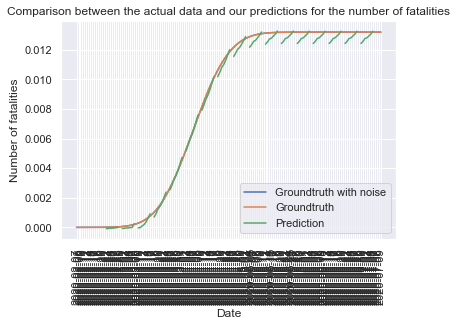

------------------------------SIR-small-84---------------------------------


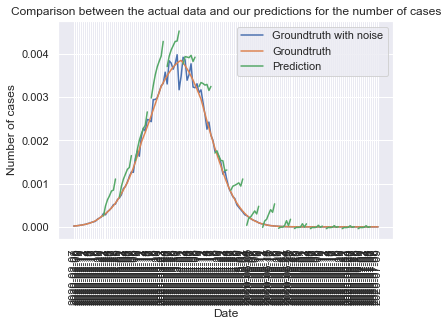

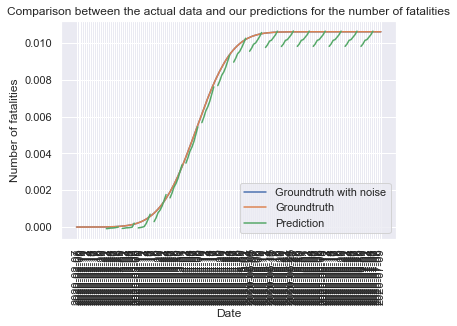

------------------------------SIR-small-85---------------------------------


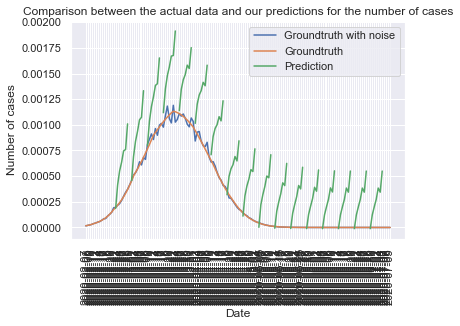

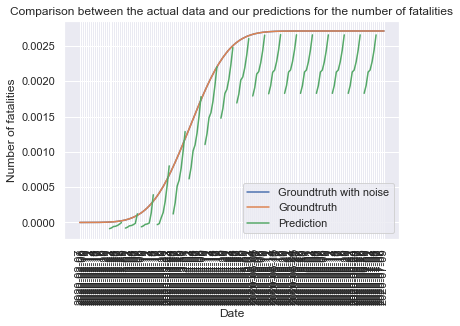

------------------------------SIR-small-86---------------------------------


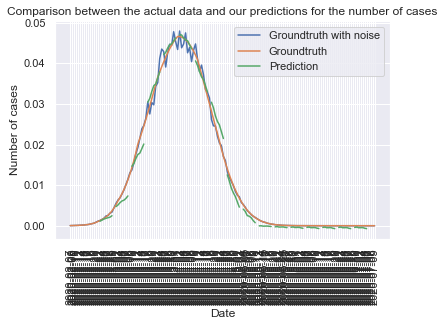

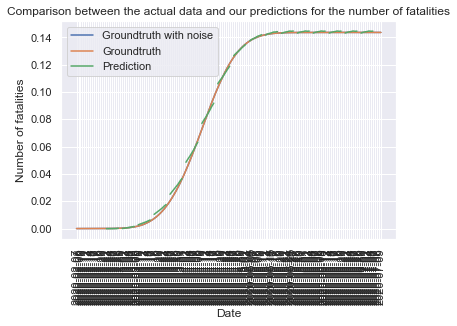

------------------------------SIR-small-87---------------------------------


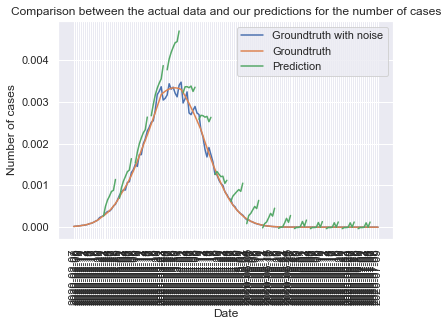

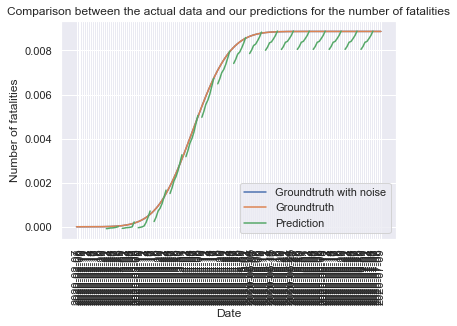

------------------------------SIR-small-88---------------------------------


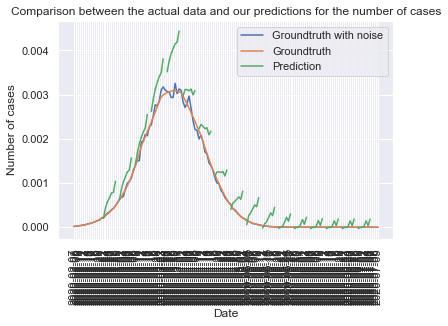

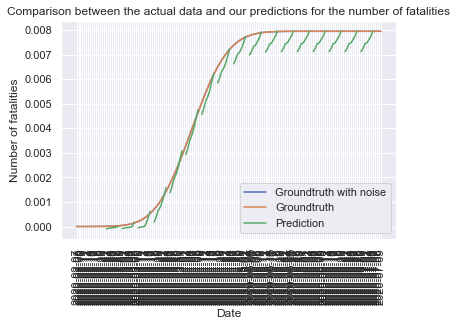

------------------------------SIR-small-89---------------------------------


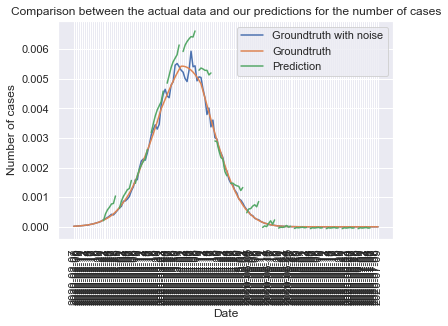

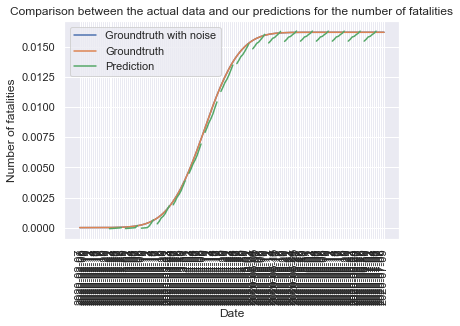

------------------------------SIR-small-90---------------------------------


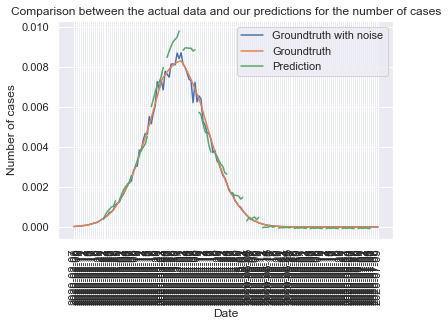

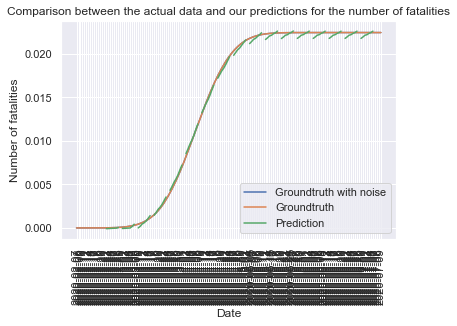

------------------------------SIR-small-91---------------------------------


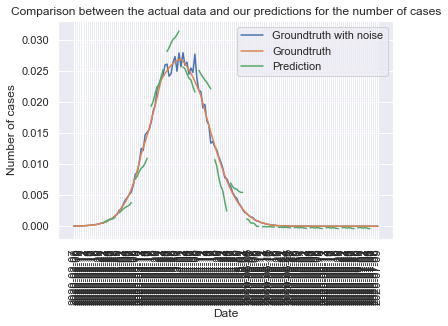

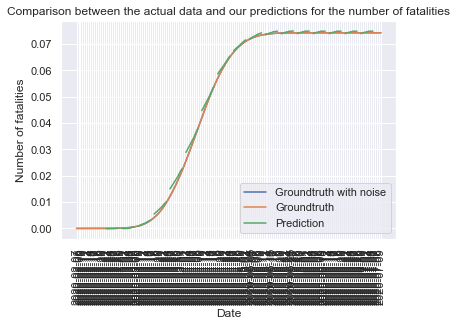

------------------------------SIR-small-92---------------------------------


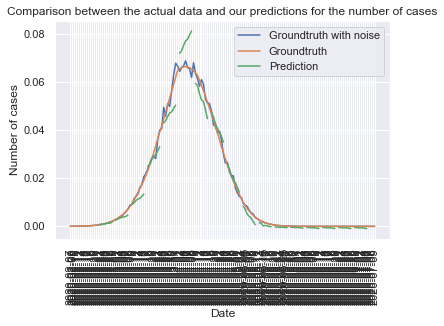

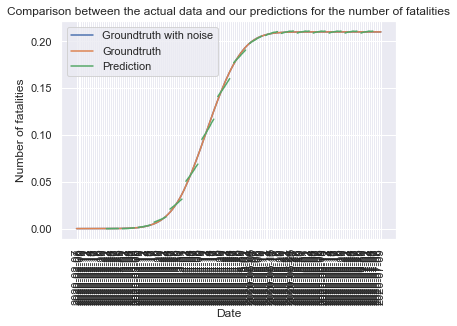

------------------------------SIR-small-93---------------------------------


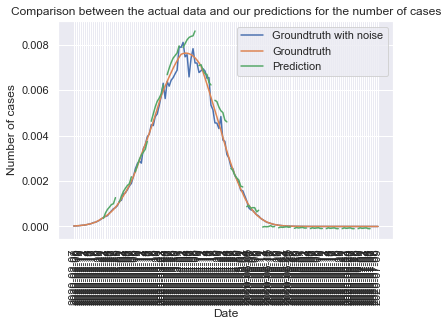

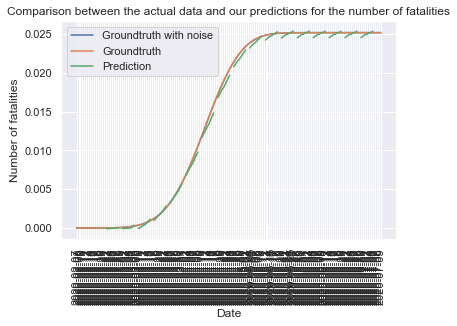

------------------------------SIR-small-94---------------------------------


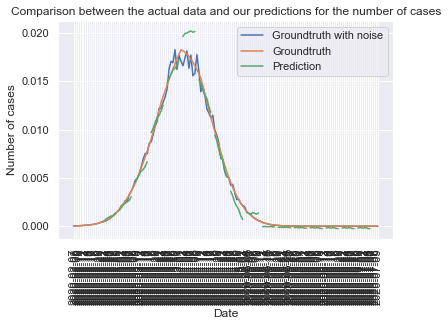

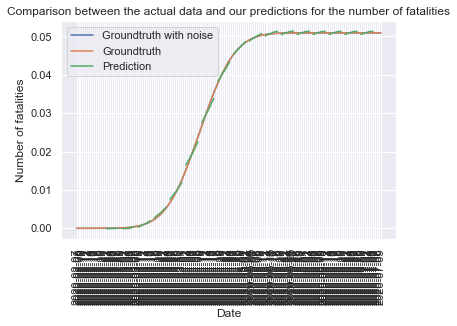

------------------------------SIR-small-95---------------------------------


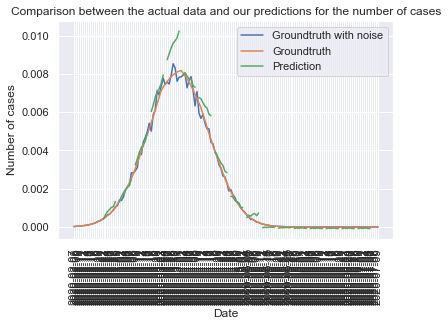

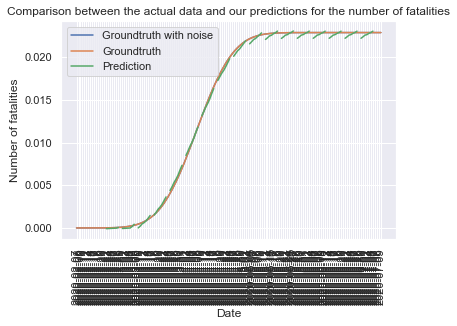

------------------------------SIR-small-96---------------------------------


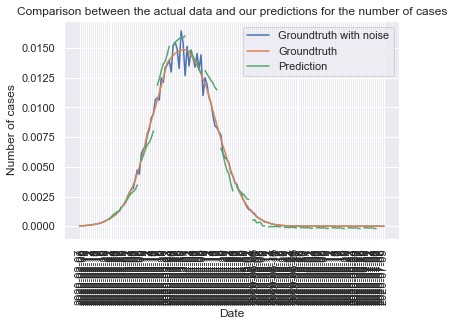

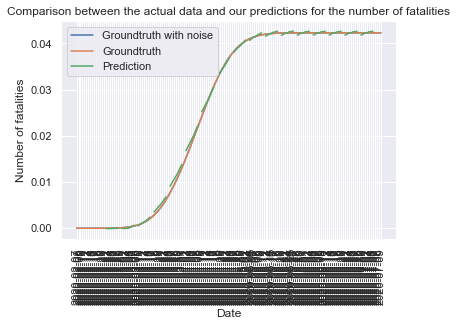

------------------------------SIR-small-97---------------------------------


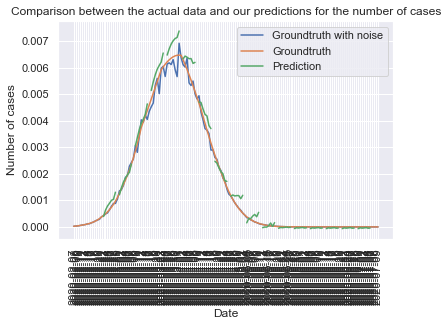

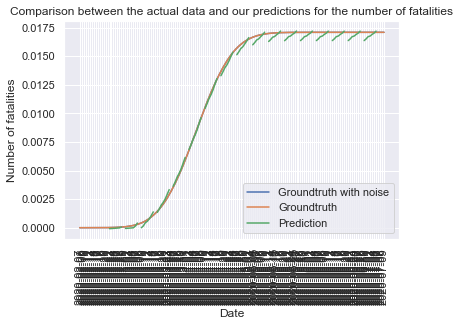

------------------------------SIR-small-98---------------------------------


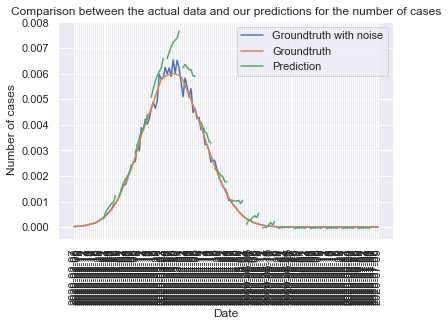

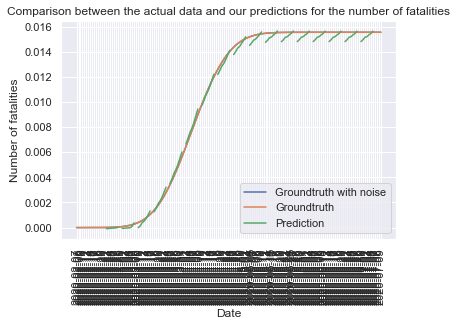

------------------------------SIR-small-99---------------------------------


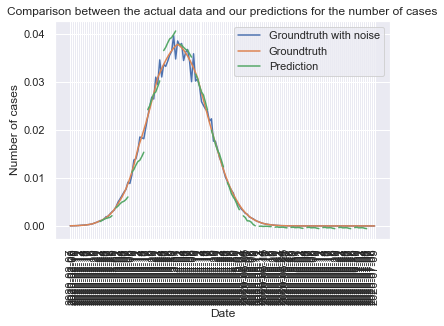

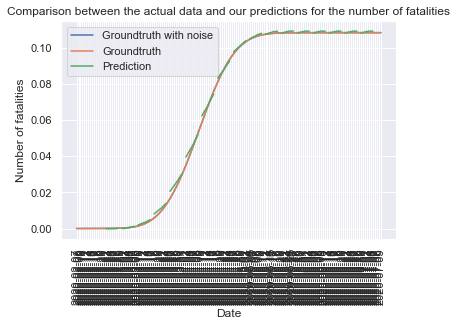

In [42]:
for code in range(81, 100):
    print("------------------------------SIR-small-{}---------------------------------".format(code))
    display_comparison_SIR("SIR-small-{}".format(code), pdf, gdf)

------------------------------KOR---------------------------------


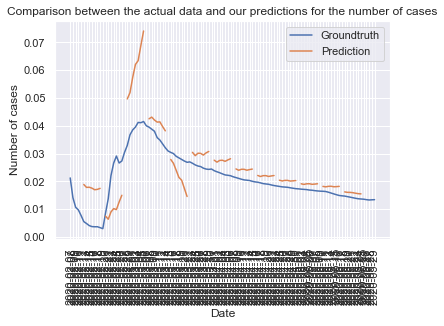

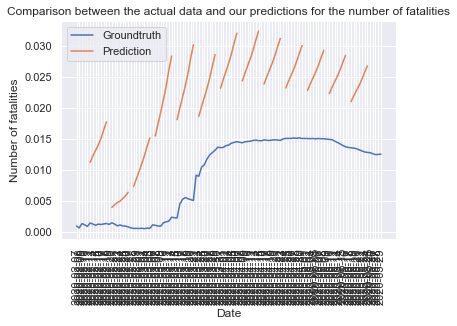

------------------------------ITA---------------------------------


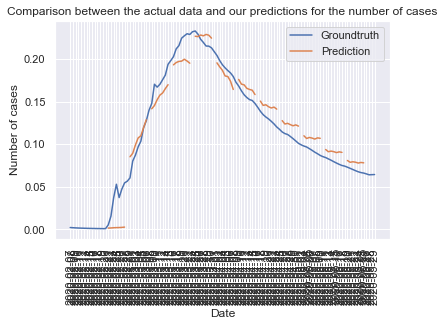

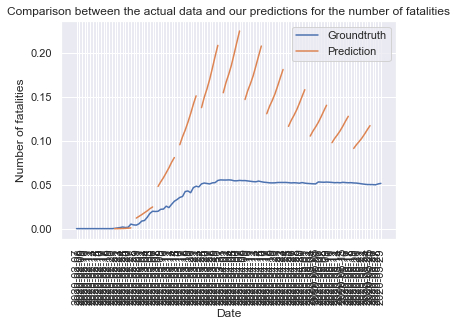

------------------------------FRA---------------------------------


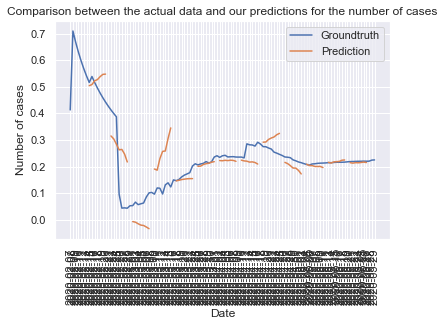

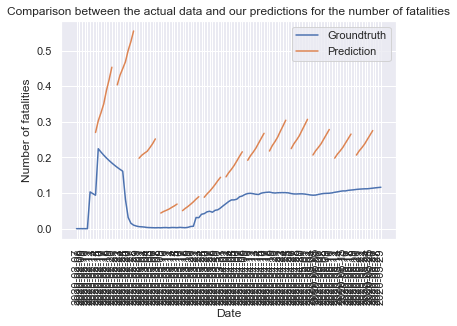

------------------------------DEU---------------------------------


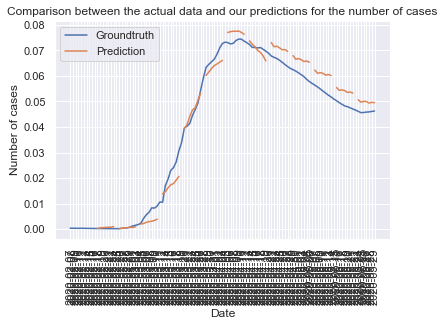

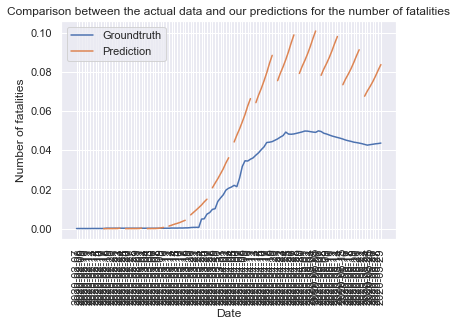

------------------------------ISL---------------------------------


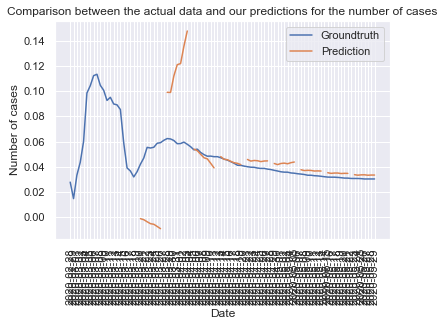

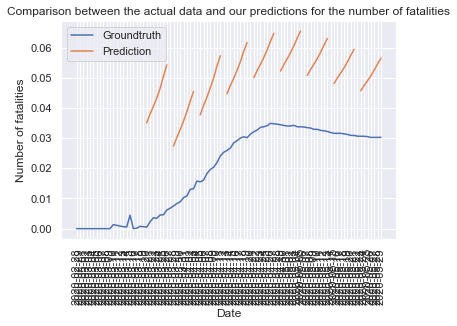

------------------------------DNK---------------------------------


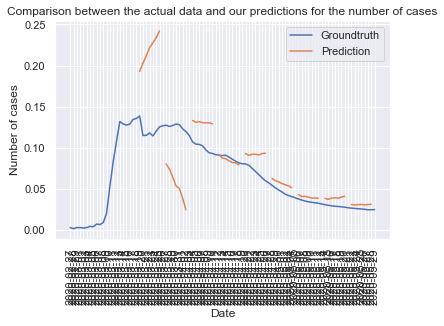

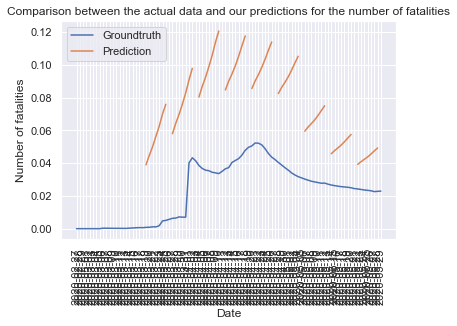

------------------------------THA---------------------------------


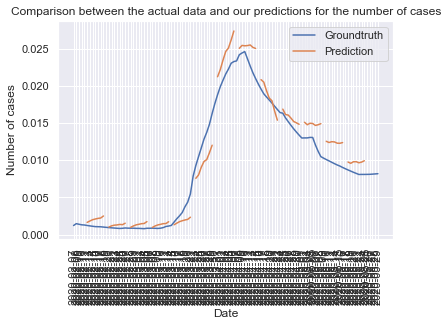

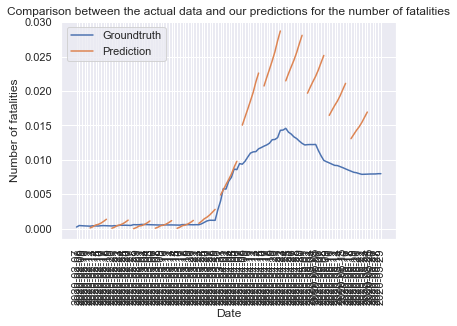

------------------------------TWN---------------------------------


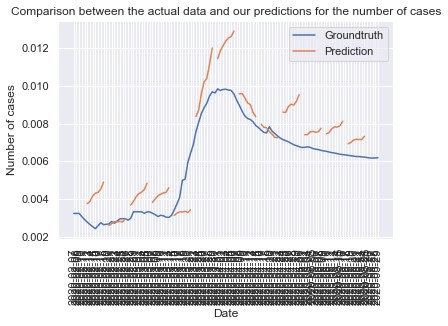

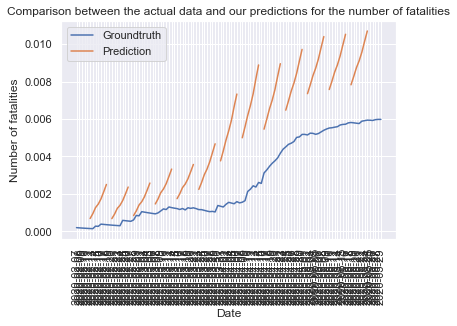

In [43]:
for code in test_country:
    print("------------------------------{}---------------------------------".format(code))
    display_comparison_region(code, cpdf, cgdf)